# Exploratory Data Analysis: Grantnav Dataset (Downloaded 20/04/2021)

**Research Question**
    
Is it possible to predict grant value from description keywords, location-based data and/or other characteristics?

## 0.0 Libraries

In [294]:
%load_ext autoreload
%autoreload 2

#system
import os
import sys
from os.path import join as pj
module_path = os.path.abspath(pj('..','..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# data
import pandas as pd
import numpy as np

# viz
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('bmh')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import missingno as msno

# configurations
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import configparser

#stats
import scipy

# utils
from src.d00_utils import print_helper_functions as phf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0.1 Configurations and Directories

In [5]:
# not used in this stub but often useful for finding various files
project_dir = Path().resolve().parents[1]
print(project_dir)

# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
_ = load_dotenv(find_dotenv())

raw_dir = pj(project_dir, 'data', os.environ.get('RAW_DIR'))
processed_dir = pj(project_dir, 'data', os.environ.get('PROCESSED_DIR'))

/Users/marclawson/repositories/grantnav_10k_predictor


## 1.0 Load Data

In [6]:
data = pd.read_csv(pj(raw_dir,'grantnav-20210420153103.csv'))

/Users/marclawson/opt/anaconda3/envs/grantnav_10k_predictor/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8,9,10,13,17,18,19,20,21,22,23,24,25,26,27,28,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,57,58,59,61,62,63,65,66,67,71,72,73,74,75) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 1.1 Examine data

### 1.1.1 Size and shape

In [14]:
data.head()
data.shape

,Identifier,Title,Description,Currency,Amount Applied For,Amount Awarded,Amount Disbursed,Award Date,URL,Planned Dates:Start Date,Planned Dates:End Date,Planned Dates:Duration (months),Actual Dates:Start Date,Actual Dates:End Date,Actual Dates:Duration (months),...,Beneficiary Location:7:Country Code,Beneficiary Location:7:Geographic Code,Beneficiary Location:7:Geographic Code Type,From An Open Call?,The following fields are not in the 360 Giving Standard and are added by GrantNav.,Data Source,Publisher:Name,Recipient Region,Recipient District,Recipient District Geographic Code,Recipient Ward,Recipient Ward Geographic Code,Retrieved for use in GrantNav,License (see note),"Note, this file also contains OS data © Crown copyright and database right 2016, Royal Mail data © Royal Mail copyright and Database right 2016, National Statistics data © Crown copyright and database right 2015 & 2016, see http://grantnav.threesixtygiving.org/datasets/ for more information."
0,360G-SE-2011020480EXCH_2012-04-16,Active Men Project,Funding under Sport England's Sportsmatch fund...,GBP,NaN,41100.0,NaN,2012-04-16,NaN,2012-04-10,2013-03-31,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Yes,NaN,https://sportengland-production-files.s3.eu-we...,Sport England,North West,Liverpool District,E08000012,Kirkdale Ward,E05000900,NaN,http://www.nationalarchives.gov.uk/doc/open-go...,NaN
1,360G-SE-2012000041EXCH_2012-04-16,Sporting Futures Leadership Academy,Funding under Sport England's Sportsmatch fund...,GBP,NaN,6000.0,NaN,2012-04-16,NaN,2012-05-01,2013-04-30,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Yes,NaN,https://sportengland-production-files.s3.eu-we...,Sport England,East Midlands,City of Derby,E06000015,Boulton Ward,E05001772,NaN,http://www.nationalarchives.gov.uk/doc/open-go...,NaN
2,360G-SE-2012000173EXCH_2012-04-16,Choices,Funding under Sport England's Sportsmatch fund...,GBP,NaN,36750.0,NaN,2012-04-16,NaN,2012-04-22,2013-04-21,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Yes,NaN,https://sportengland-production-files.s3.eu-we...,Sport England,North West,Liverpool District,E08000012,Greenbank Ward,E05000898,NaN,http://www.nationalarchives.gov.uk/doc/open-go...,NaN
3,360G-SE-2012000554EXCH_2012-04-16,Florrie Sports,Funding under Sport England's Sportsmatch fund...,GBP,NaN,15000.0,NaN,2012-04-16,NaN,2012-04-23,2013-03-31,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Yes,NaN,https://sportengland-production-files.s3.eu-we...,Sport England,North West,Liverpool District,E08000012,Princes Park Ward,E05000906,NaN,http://www.nationalarchives.gov.uk/doc/open-go...,NaN
4,360G-SE-2010011194LOTT_2012-04-17,Engaging children and adults in Kwic Cricket s...,Funding under Sport England's Small Grants fun...,GBP,NaN,692.0,NaN,2012-04-17,NaN,2012-04-16,2012-07-18,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Yes,NaN,https://sportengland-production-files.s3.eu-we...,Sport England,North East,Sunderland District,E08000024,Washington East Ward,E05001174,NaN,http://www.nationalarchives.gov.uk/doc/open-go...,NaN


(561424, 79)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561424 entries, 0 to 561423
Data columns (total 79 columns):
 #   Column                                                                                                                                                                                                                                                                                                Non-Null Count   Dtype  
---  ------                                                                                                                                                                                                                                                                                                --------------   -----  
 0   Identifier                                                                                                                                                                                                                                  

### 1.1.2 Grant Value Statistics (Handling Outliers)

In [188]:
grant_value = data['Amount Awarded']
phf.print_full(grant_value.describe())

count             561,424.00
mean              193,661.21
std             5,068,327.81
min          -121,020,265.00
25%                 4,000.00
50%                 9,854.00
75%                45,300.00
max         1,837,000,000.00
Name: Amount Awarded, dtype: float64

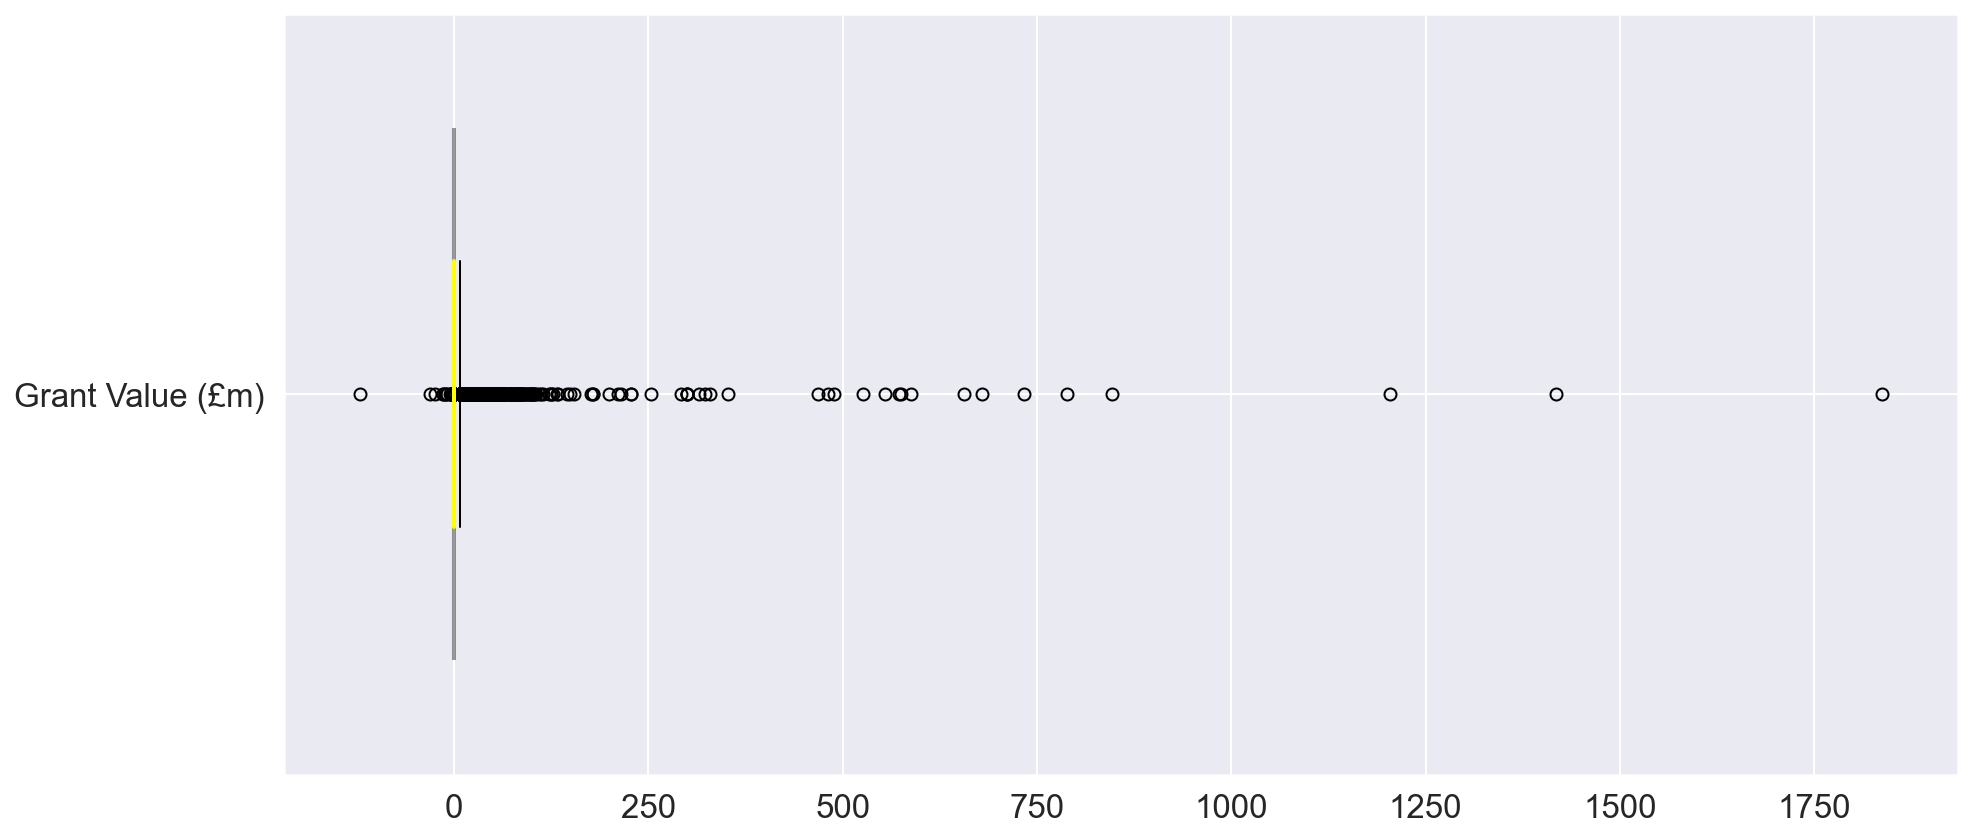

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
kwargs = {
    'vert': False,
    'whis': [0.3,99.7],
    'notch': True,
    'labels': [f'Grant Value (\u00A3m)'],
    'widths': .7,
    'patch_artist': True,
    'medianprops': dict(linestyle='-', linewidth=2, color='Yellow'),
    'boxprops': dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4)
}
ax.boxplot(grant_value/1000000, **kwargs)
plt.show();

The dataset is skewed to the right with 75% of the values 45k or less.  There is a large minus figure and even larger figure at the other end.  Let's try cutting some out.

I have called this project 'grantnav_10k_predictor' because whilst doing some preliminary work it became obvious that the dataset contained extreme values that needed addressing, and that the power of this dataset in predicting value is going to be with most of the grants of much lower values than the 1.83bn high value.  My guess was 10k but below will be an investigation of exactly which values should remain in the analysis. 

In [244]:
grant_value = data.set_index('Identifier')['Amount Awarded']
percentiles = [scipy.stats.percentileofscore(grant_value, g, kind='mean') for g in grant_value]
grant_value = pd.DataFrame(grant_value)

In [245]:
grant_value['percentiles'] = percentiles

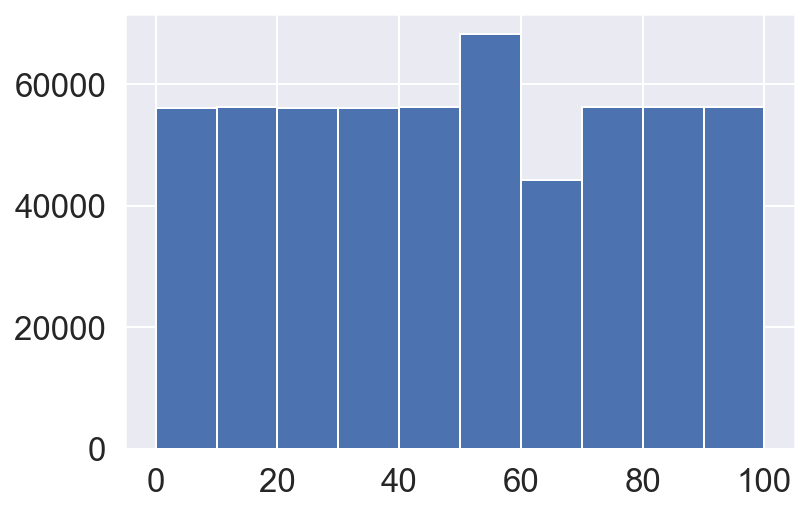

In [248]:
grant_value['percentiles'].hist();

In [321]:
phf.print_full(grant_value.sort_values('percentiles', ascending=False).head())
phf.print_full(grant_value.sort_values('percentiles', ascending=False).tail())

,Amount Awarded,percentiles,award_percs,award_std
Identifier,,,,
360G-cabinetoffice-GA-240191,"1,837,000,000.00",100.00,362.41,362.41
360G-cabinetoffice-GA-060717,"1,418,364,000.00",100.00,279.81,279.81
360G-cabinetoffice-GA-318586,"1,204,500,000.00",100.00,237.61,237.61
360G-cabinetoffice-GA-248538,"846,677,305.00",100.00,167.01,167.01
360G-cabinetoffice-GA-248535,"788,700,000.00",100.00,155.58,155.58


,Amount Awarded,percentiles,award_percs,award_std
Identifier,,,,
360G-cabinetoffice-GA-248534,"-13,909,000.00",0.00,-2.78,-2.78
360G-cabinetoffice-GA-319658,"-14,240,000.00",0.00,-2.85,-2.85
360G-cabinetoffice-GA-326095,"-24,883,502.00",0.00,-4.95,-4.95
360G-cabinetoffice-GA-320424,"-31,056,173.42",0.00,-6.17,-6.17
360G-cabinetoffice-GA-324152,"-121,020,265.00",0.00,-23.92,-23.92


In [250]:
grant_value.mean()
grant_value[(grant_value['percentiles']>=5) & (grant_value['percentiles']<=95)].mean()

Amount Awarded    193661.207432
percentiles           50.000000
dtype: float64

Amount Awarded    40954.954460
percentiles          49.999911
dtype: float64

In [331]:
score = 45
df_outliers_removed = grant_value[(grant_value['percentiles']>=score) & (grant_value['percentiles']<=100-score)]
phf.print_full(df_outliers_removed.sort_values('percentiles', ascending=False).head())
phf.print_full(df_outliers_removed.sort_values('percentiles', ascending=False).tail())

,Amount Awarded,percentiles,award_percs,award_std
Identifier,,,,
360G-tnlcomfund-0031014378,"9,999.99",54.10,-0.04,-0.04
360G-tnlcomfund-0031020436,"9,999.98",54.10,-0.04,-0.04
360G-tnlcomfund-0031020026,"9,999.96",54.10,-0.04,-0.04
360G-tnlcomfund-0031015463,"9,999.96",54.10,-0.04,-0.04
360G-tnlcomfund-0031014938,"9,999.95",54.10,-0.04,-0.04


,Amount Awarded,percentiles,award_percs,award_std
Identifier,,,,
360G-cabinetoffice-GA-060354,"9,062.00",45.00,-0.04,-0.04
360G-tnlcomfund-0031012970,"9,062.00",45.00,-0.04,-0.04
360G-tnlcomfund-0030010792,"9,062.00",45.00,-0.04,-0.04
360G-tnlcomfund-0010327388,"9,062.00",45.00,-0.04,-0.04
360G-tnlcomfund-0030011364,"9,062.00",45.00,-0.04,-0.04


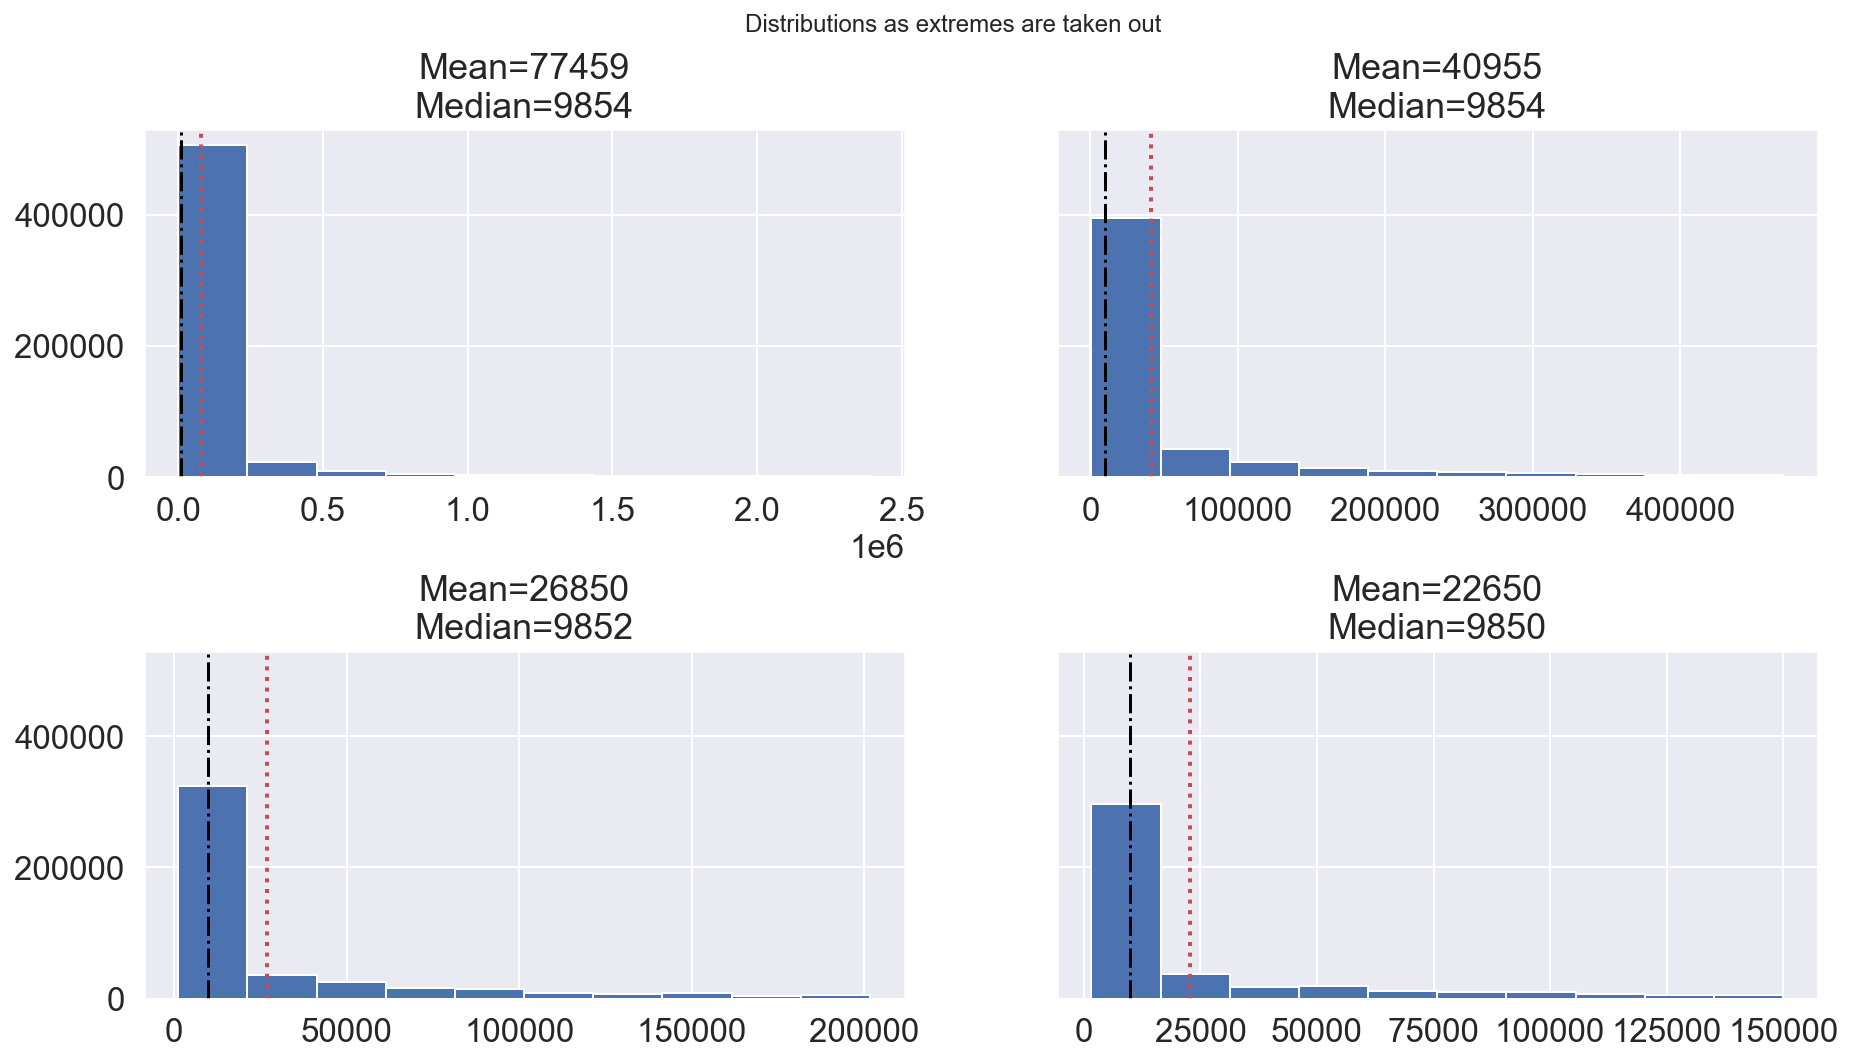

In [336]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,8), sharey=True)
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions as extremes are taken out')

outlier_scores = [1, 5, 10, 12.5] 
for ax, score in zip(axes.flatten(), outlier_scores):
    ys = grant_value[(grant_value['percentiles']>=score) & (grant_value['percentiles']<=(100-score))]['Amount Awarded'].values
    ax.hist(ys)
    ax.axvline(int(round(ys.mean(),0)), color='r', linestyle=':', linewidth=2)
    ax.axvline(int(round(np.median(ys),0)), color='black', linestyle='-.', linewidth=1.5)
    ax.set_title(f"Mean={int(round(ys.mean(),0))}\nMedian={int(round(np.median(ys),0))}")
plt.show();

### 1.1.3 Null values

There seems to be a lot of null columns here.  I should check this and remove un- or partially-filled columns.  There are also obviously redundant columns at the end.  It would be helpful to visualise the nulls.

<AxesSubplot:>

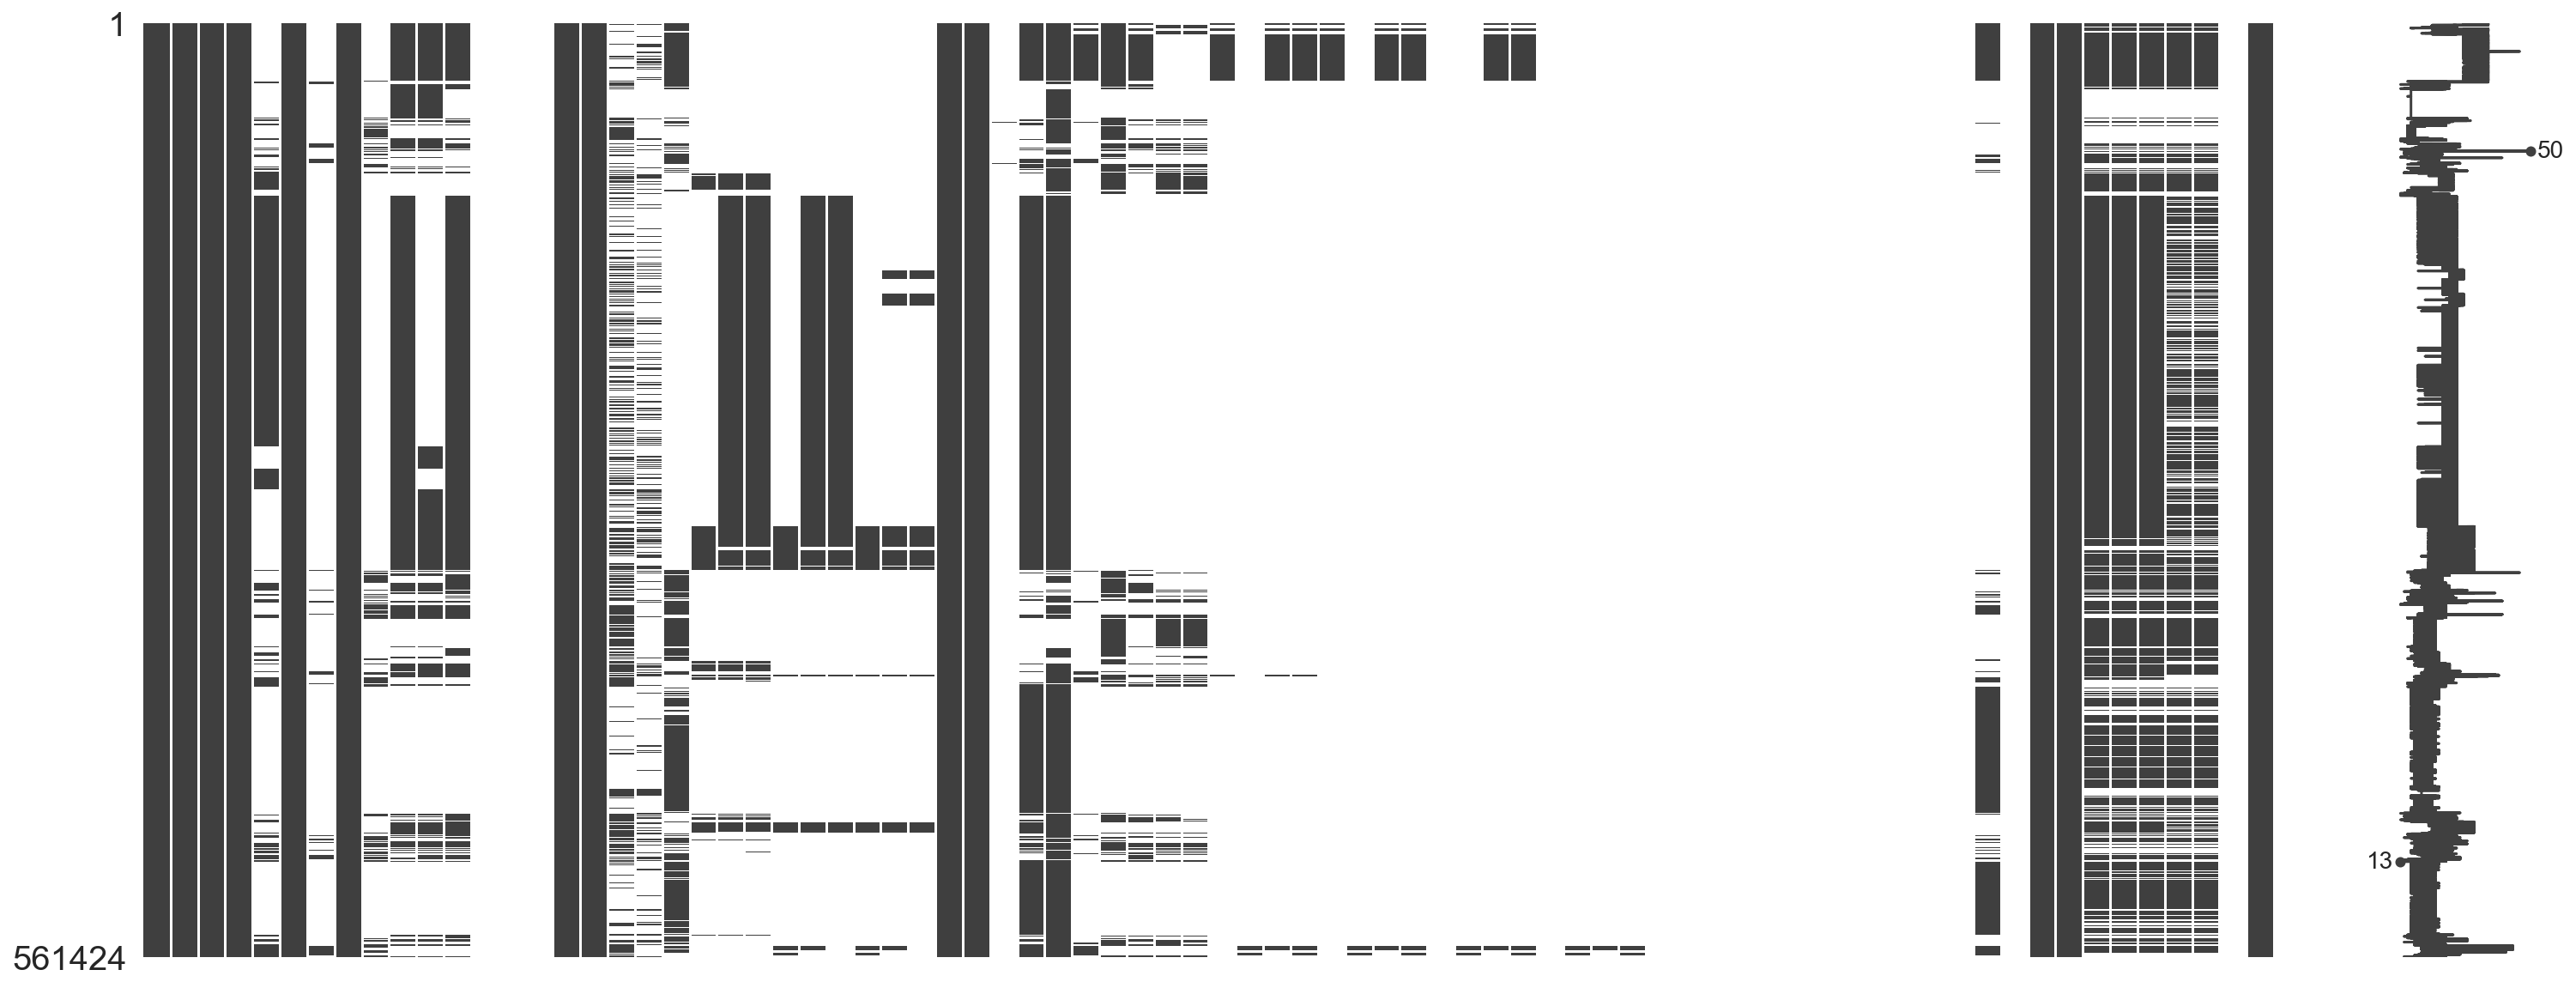

In [20]:
msno.matrix(data)

In [69]:
df_nonullcols = data.dropna(how='all', axis=1)
df_nonullcols = df_nonullcols[[c for c in df_nonullcols.columns if c not in ['License (see note)', 'Data Source', 'From An Open Call?']]]

There should be a threshold for the number of null values I'm willing to accept: Filter columns that don't meet the threshold.

------------------------------------------------------------------------------------------------------------------------
0.0: 


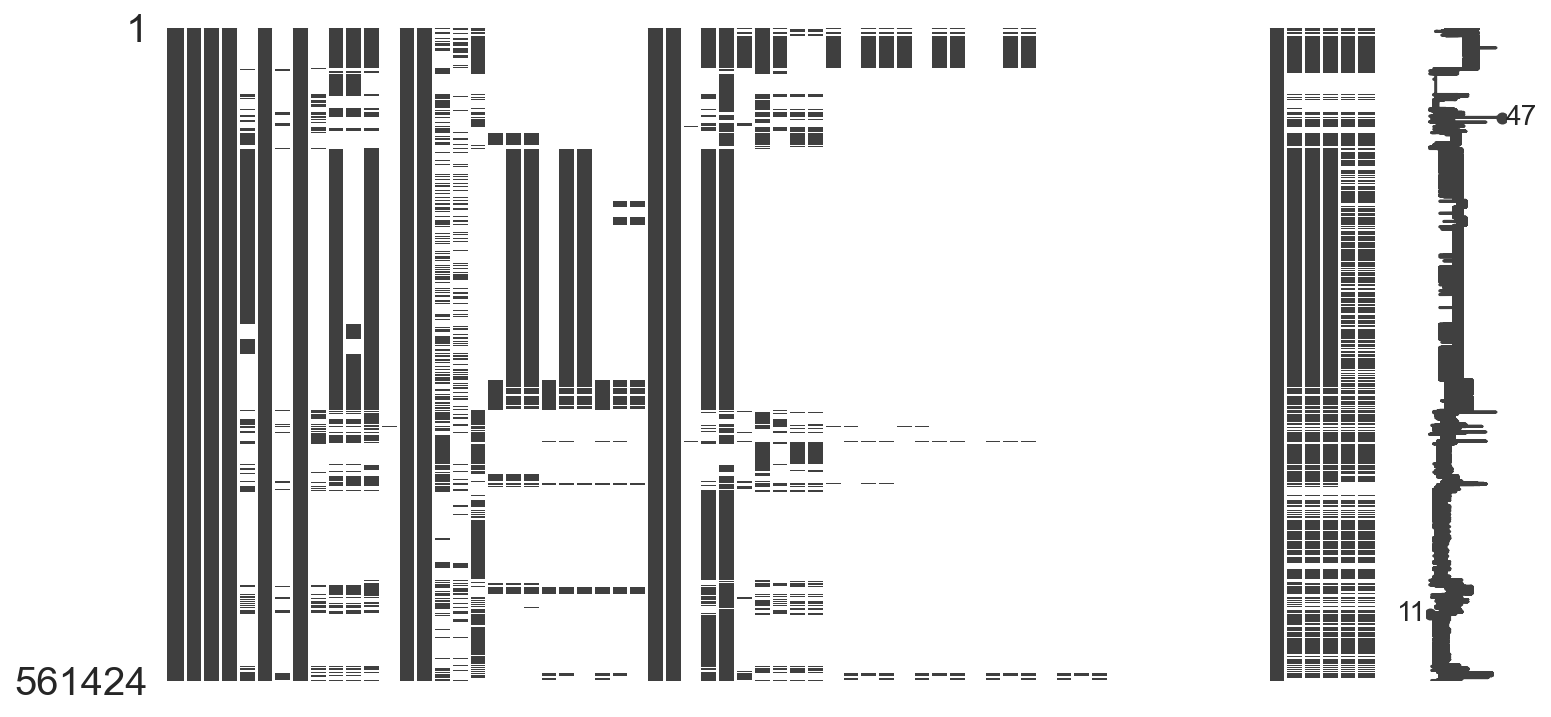

Number of columns: 68 (100.0% remaining)
Columns removed:
[]
END OF ITERATION [0.0]


------------------------------------------------------------------------------------------------------------------------
0.17: 


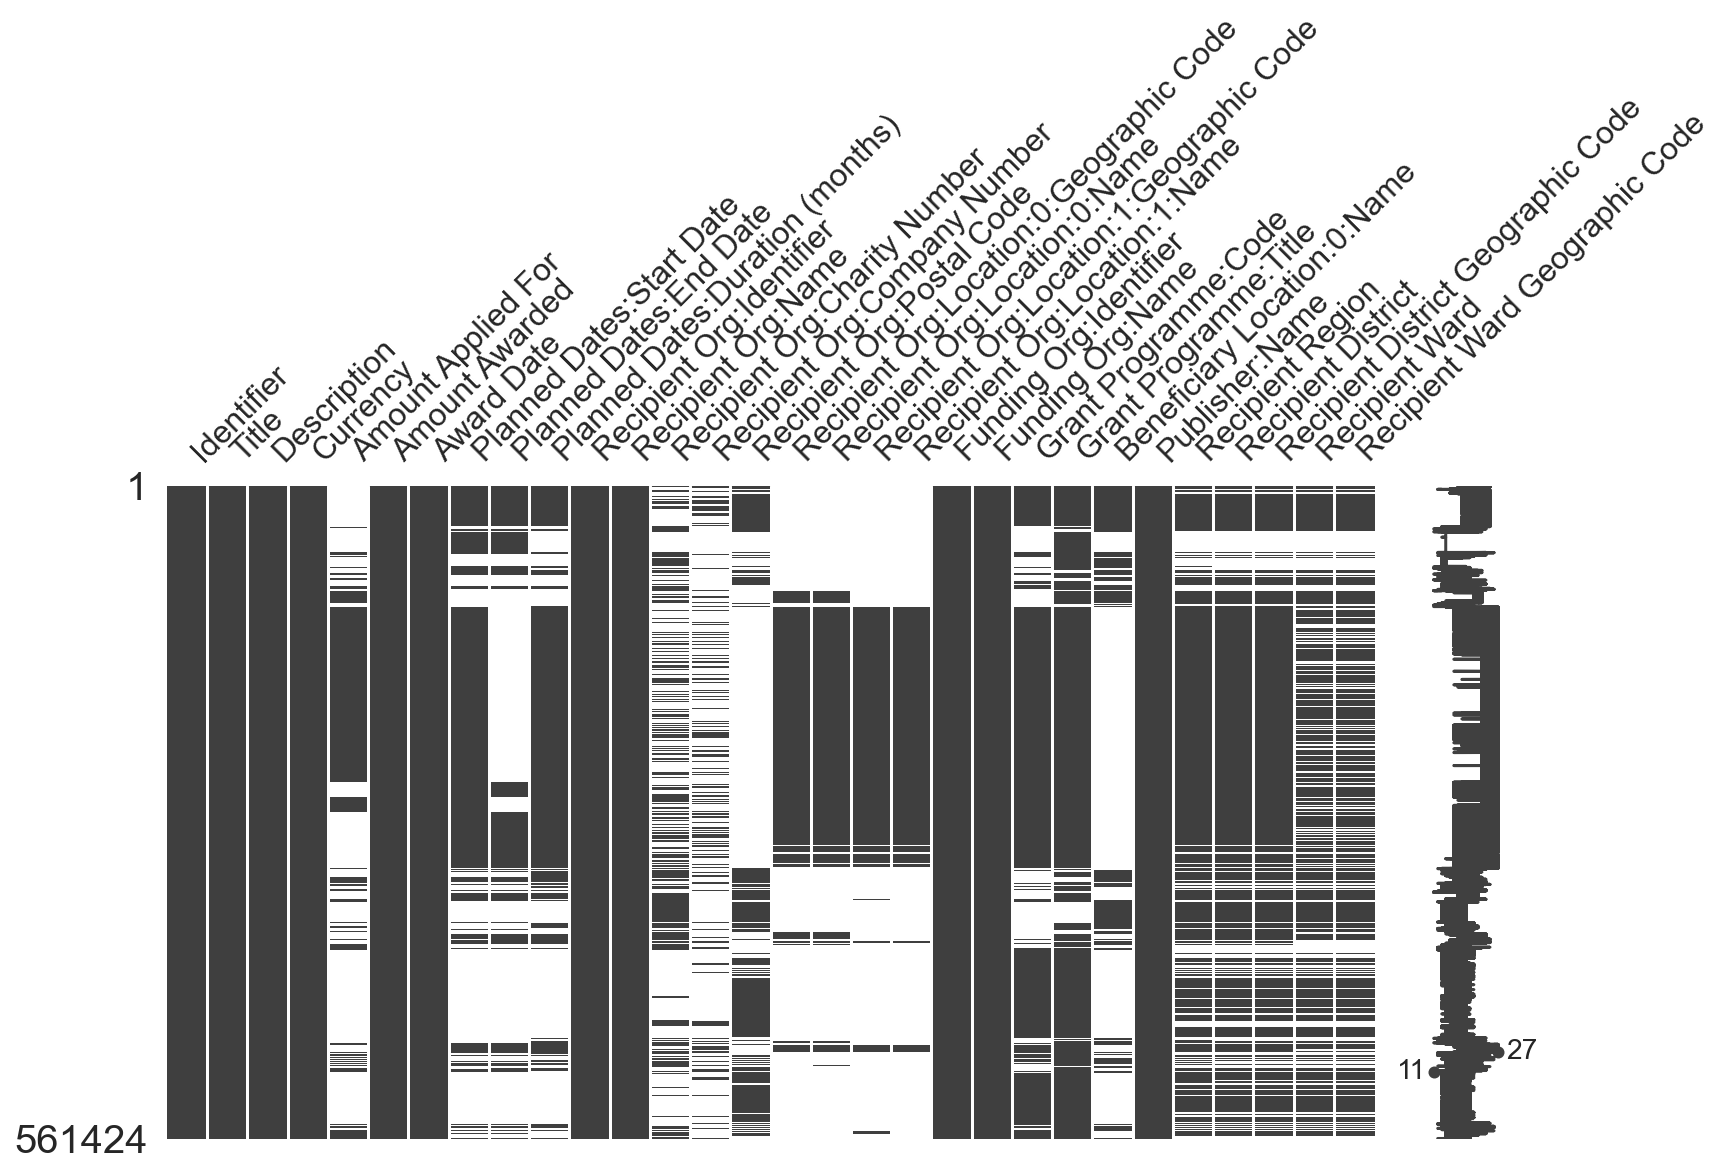

Number of columns: 30 (44.1% remaining)
Columns removed:
['Beneficiary Location:4:Geographic Code', 'Beneficiary Location:6:Geographic Code', 'Recipient Org:Location:0:Geographic Code Type', 'Beneficiary Location:5:Name', 'Beneficiary Location:4:Geographic Code Type', 'Recipient Org:Location:1:Geographic Code Type', 'Beneficiary Location:2:Geographic Code Type', 'Beneficiary Location:4:Name', 'Recipient Org:Location:2:Geographic Code Type', 'Beneficiary Location:7:Geographic Code', 'Beneficiary Location:1:Geographic Code Type', 'Recipient Org:Location:2:Name', 'Beneficiary Location:3:Geographic Code Type', 'Beneficiary Location:6:Name', 'URL', 'Beneficiary Location:5:Geographic Code Type', 'Beneficiary Location:1:Geographic Code', 'Beneficiary Location:1:Name', 'Beneficiary Location:7:Geographic Code Type', 'Beneficiary Location:3:Name', 'Beneficiary Location:0:Country Code', 'Recipient Org:Location:2:Geographic Code', 'Beneficiary Location:6:Geographic Code Type', 'Beneficiary Locatio

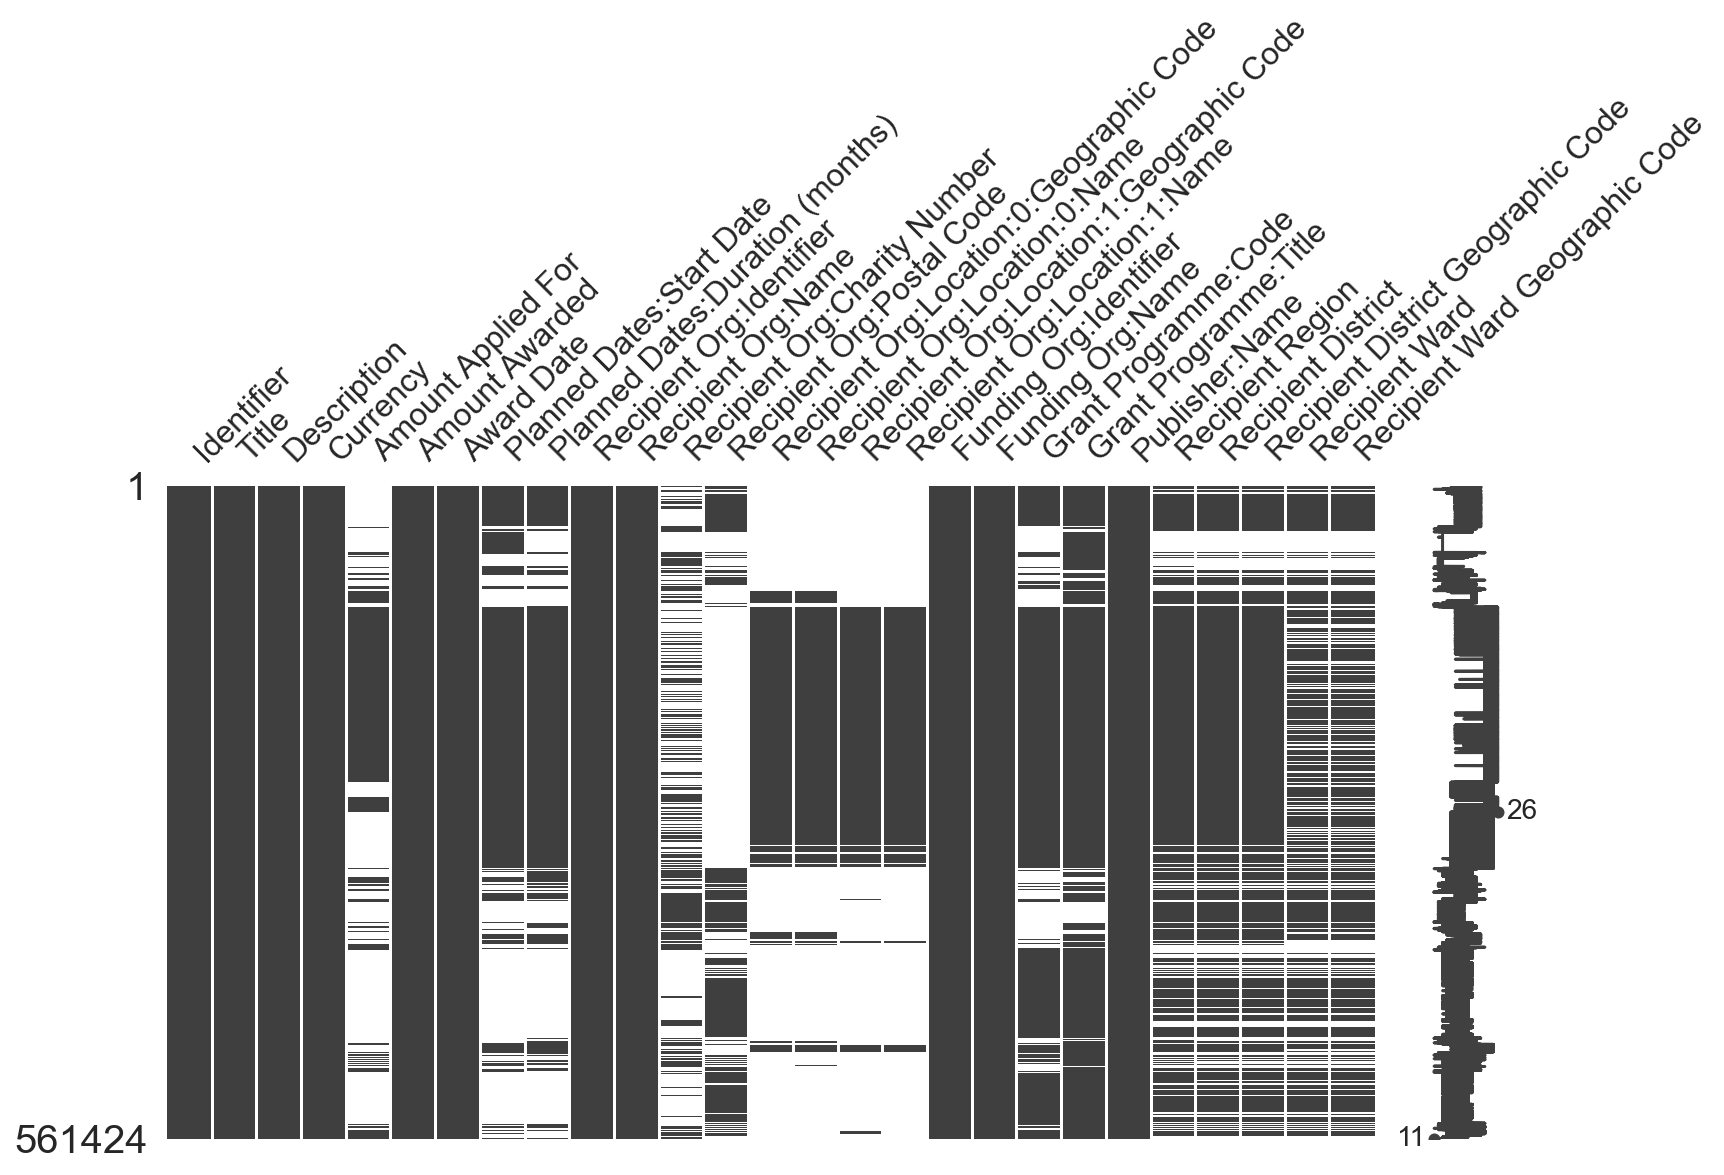

Number of columns: 27 (39.7% remaining)
Columns removed:
['Recipient Org:Company Number', 'Planned Dates:End Date', 'Beneficiary Location:0:Name']
END OF ITERATION [0.33]


------------------------------------------------------------------------------------------------------------------------
0.5: 


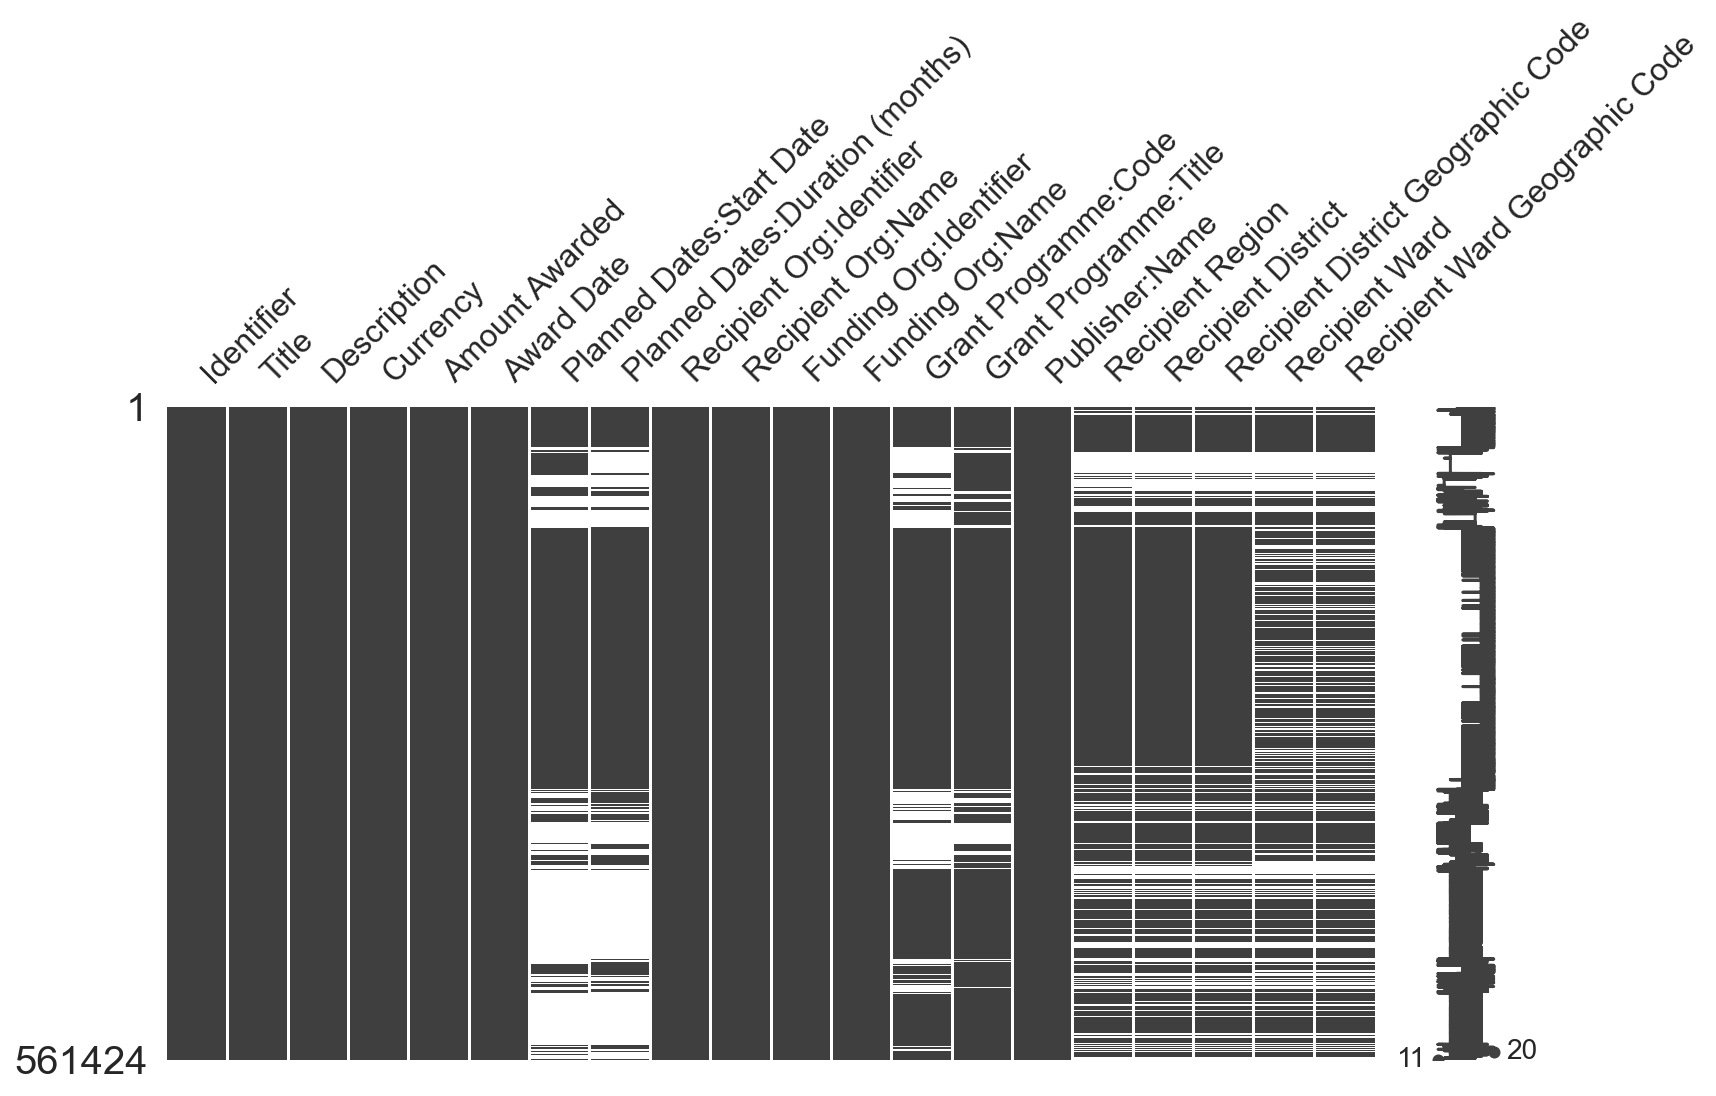

Number of columns: 20 (29.4% remaining)
Columns removed:
['Recipient Org:Location:1:Name', 'Recipient Org:Location:0:Geographic Code', 'Recipient Org:Charity Number', 'Recipient Org:Location:1:Geographic Code', 'Recipient Org:Postal Code', 'Recipient Org:Location:0:Name', 'Amount Applied For']
END OF ITERATION [0.5]


------------------------------------------------------------------------------------------------------------------------
0.67: 


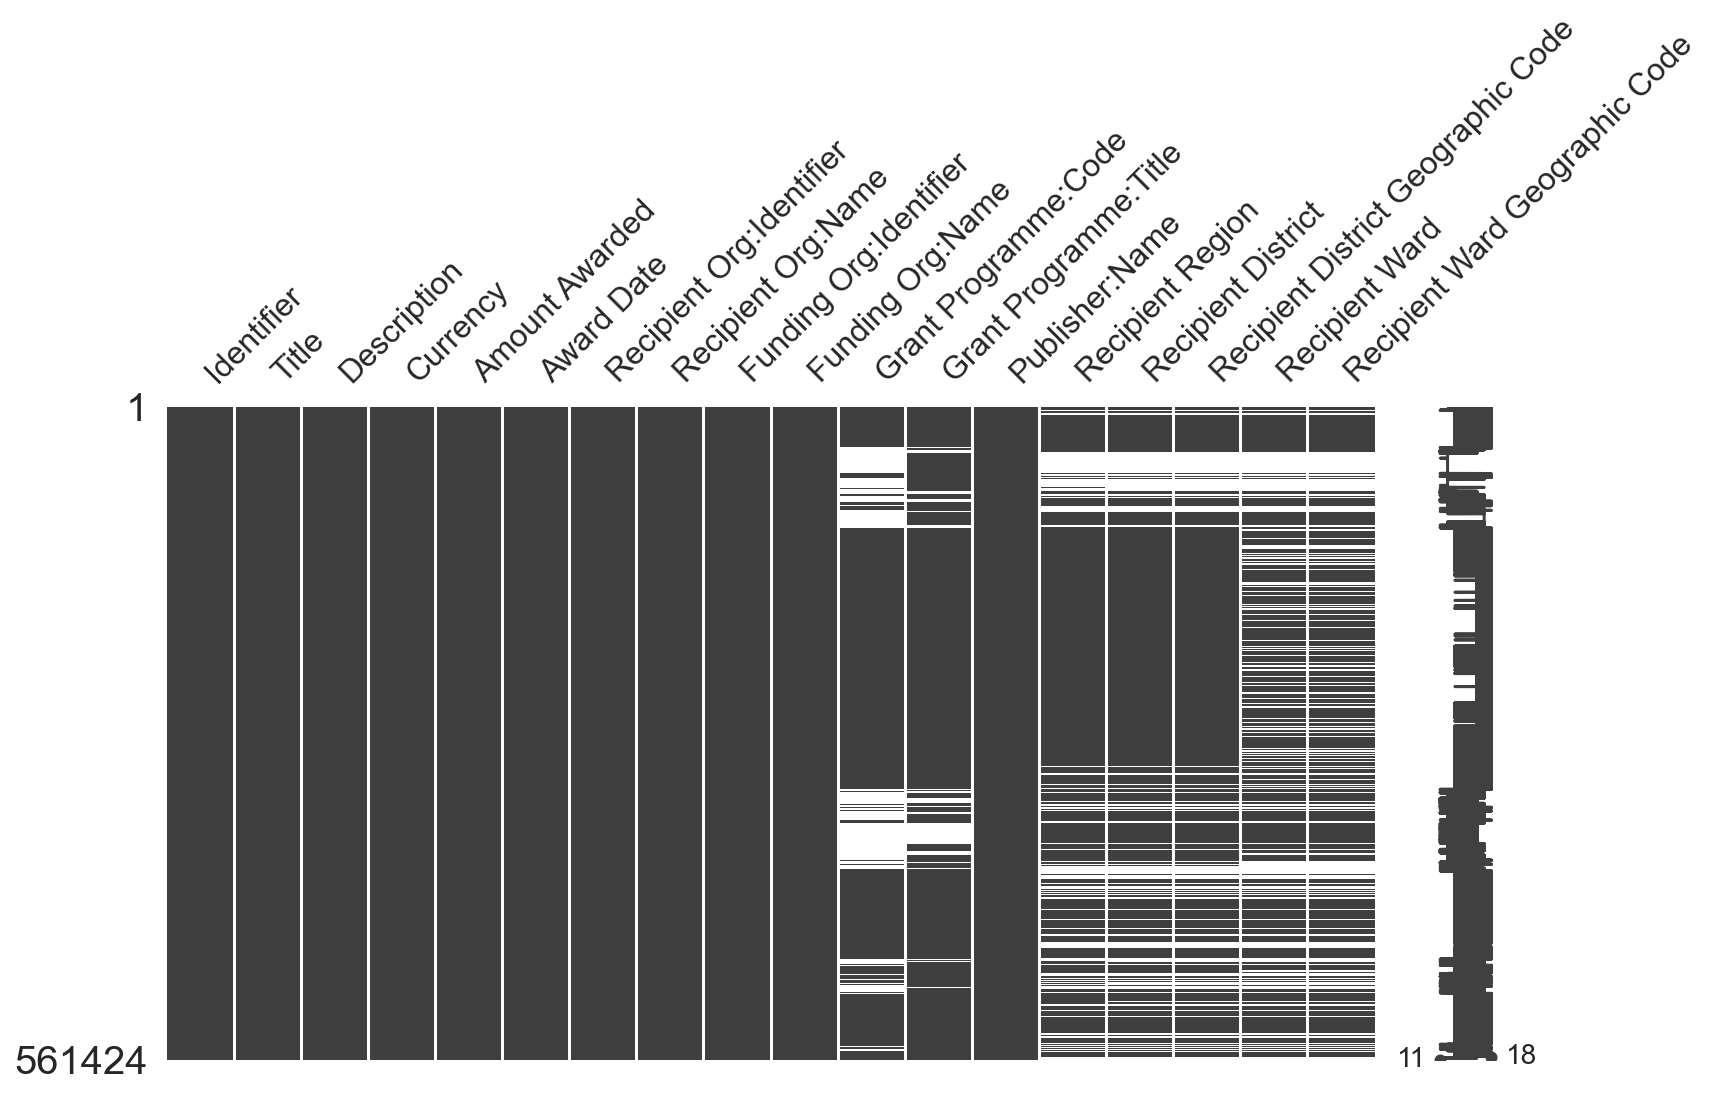

Number of columns: 18 (26.5% remaining)
Columns removed:
['Planned Dates:Start Date', 'Planned Dates:Duration (months)']
END OF ITERATION [0.67]


------------------------------------------------------------------------------------------------------------------------
0.83: 


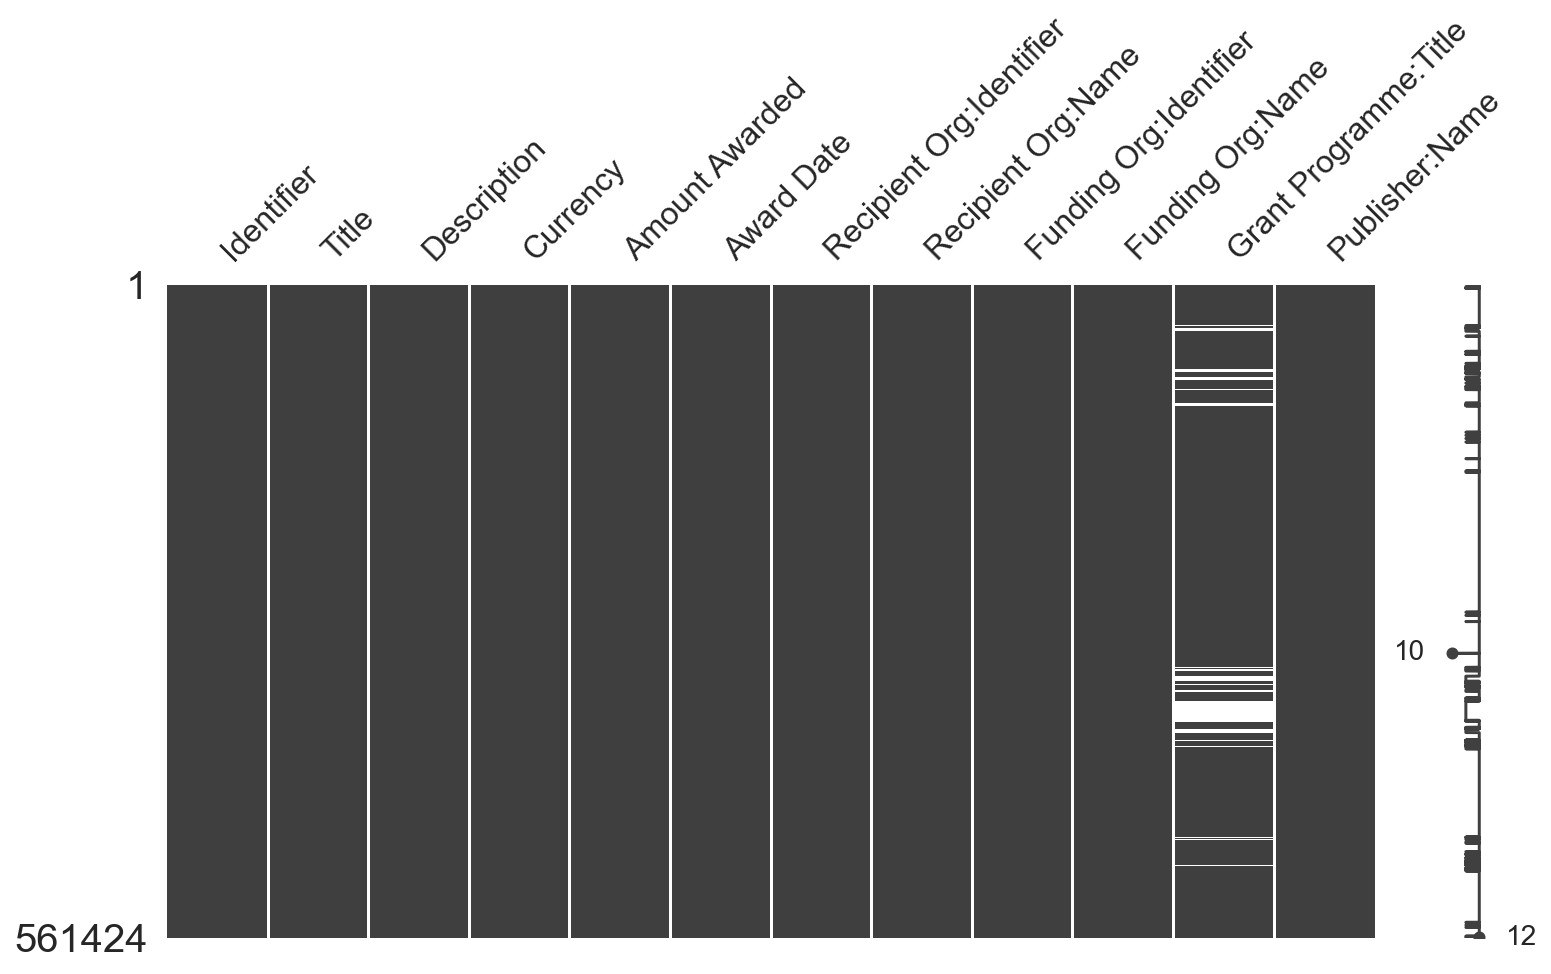

Number of columns: 12 (17.6% remaining)
Columns removed:
['Recipient Ward', 'Recipient Ward Geographic Code', 'Recipient Region', 'Grant Programme:Code', 'Recipient District', 'Recipient District Geographic Code']
END OF ITERATION [0.83]


------------------------------------------------------------------------------------------------------------------------
1.0: 


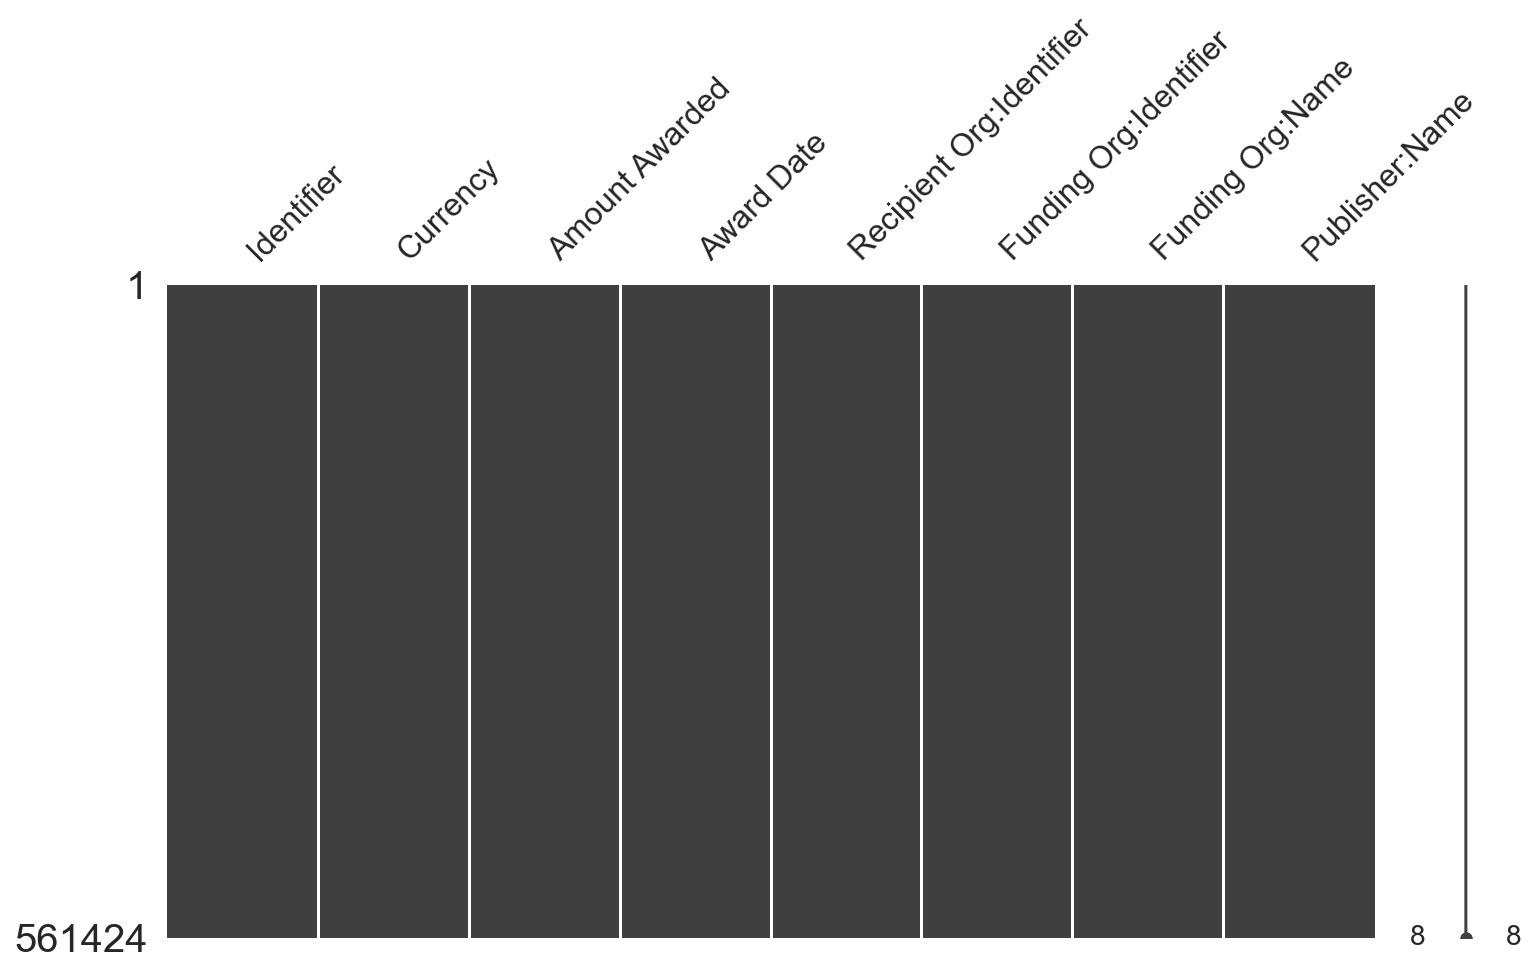

Number of columns: 8 (11.8% remaining)
Columns removed:
['Description', 'Grant Programme:Title', 'Title', 'Recipient Org:Name']
END OF ITERATION [1.0]




In [118]:
removed_cols = []
removed_cols_by_thresh = {}
for i in np.linspace(0, 1, 7):
    above_thresh_columns = [c for c in df_nonullcols.columns if df_nonullcols[c].value_counts().sum()/df_nonullcols.shape[0]>=i]
    below_thresh_columns = [c for c in df_nonullcols.columns if c not in above_thresh_columns]
    df = df_nonullcols[above_thresh_columns]
    new_removed_cols = [c for c in set(below_thresh_columns) if c not in set(removed_cols)]
    removed_cols.extend(below_thresh_columns)
    msno.matrix(df, figsize=(12,6))
    print('-'*120)
    print(f"{round(i,2)}: ")
    plt.show();
    print(f"Number of columns: {df.shape[1]} ({round((df.shape[1]/df_nonullcols.shape[1])*100,1):,.1f}% remaining)")
    print(f"Columns removed:\n{new_removed_cols}")
    removed_cols_by_thresh[round(i,2)] = {'keep': above_thresh_columns, 'remove': new_removed_cols}
    print(f"END OF ITERATION [{round(i,2)}]")
    print()
    print()
plt.show();

#### 1.1.3.1 Columns for threshold 0.33 - 0.5

Accepting columns with at most half of values being null allows us to examine beneficiary but not for the one-third null-valued columns.  A lot of the columns that have been removed between 0.5 and 0.33 contain the recipient geography data and a few other potentially useful measures.  

Q: **Do we need these columns?**

In [115]:
# drop rows in the 0.33 - 0.5 threshold range and check
columns_to_compare = []
for k, v in removed_cols_by_thresh.items(): # thresh/columns
        if .33 < k <= .5:
            for c in v['remove']:
                df = df_nonullcols[v['keep']+v['remove']].dropna(subset=[c])
                print(f"{c}: {df.shape[0]} rows")

Recipient Org:Location:1:Name: 228633 rows
Recipient Org:Location:0:Geographic Code: 248827 rows
Recipient Org:Charity Number: 219985 rows
Recipient Org:Location:1:Geographic Code: 231369 rows
Recipient Org:Postal Code: 228635 rows
Recipient Org:Location:0:Name: 249345 rows
Amount Applied For: 225525 rows


One column of interest is `Beneficiary Location:0:Name` as where a grant is spent could predict a value of a grant.  The geographic code for this was dropped between threshold 0 - 0.33, which could cause an issue if we need to match names.  To keep this column, the number of rows would reduce to 144,678 (out of 561,424).

The other column of interest is `Recipient Org:Location:0:Geographic Code` for the same reason.  This would leave around 100k more rows than benficiary name.  However, the higher thresholds are recording geographical info for region, district and ward so may not be critical.

Another column that could be of interest is `Amount Applied For`.  This is recorded for around half of the rows in the dataset.  The question is whether this is useful enough for us to sample half of the organisations.  

Q: **Which funders are recording `Amount Applied For`?**

In [164]:
phf.print_full(round(df_nonullcols.groupby('Funding Org:Name')['Amount Applied For'].count().sort_values(ascending=False)\
        /df_nonullcols.groupby('Funding Org:Name')['Amount Applied For'].count().sort_values(ascending=False).sum()*100,1).head(10))

Funding Org:Name
The National Lottery Community Fund                                          72.40
The National Lottery Heritage Fund                                            4.50
Scottish Government                                                           2.40
Northern Rock Foundation                                                      1.90
Community Foundation serving Tyne & Wear and Northumberland                   1.80
Quartet Community Foundation                                                  1.60
City Bridge Trust                                                             1.40
Paul Hamlyn Foundation                                                        1.20
Community Foundation for Surrey                                               1.00
Suffolk Community Foundation                                                  0.90
Name: Amount Applied For, dtype: float64

Most of the data for `Amount Applied For` is provided by one organisation, `The National Lottery Community Fund`.  How does this compare to the overall completion pattern for data?

In [166]:
round(df_nonullcols['Funding Org:Name'].value_counts(normalize=True)*100,1).head(10)

The National Lottery Community Fund                        41.2
Department for Education                                    6.9
Sport England                                               5.5
Department for Business, Energy and Industrial Strategy     4.7
The Wellcome Trust                                          3.1
Co-operative Group                                          2.9
The National Lottery Heritage Fund                          1.8
Department for Environment, Food and Rural Affairs          1.6
Ministry for Housing, Communities and Local Government      1.3
Garfield Weston Foundation                                  1.2
Name: Funding Org:Name, dtype: float64

Less than half of all data comes from `The National Lottery Community Fund` so is less than the completion rate for `Amount Applied For` but is still a siginificant percentage.  It may be that data has to be separated for this organisation.  However, for present purposes `Amount Applied For` could be used for `The National Lottery Community Fund` but perhaps not for others.

#### 1.1.3.2 Columns for threshold 0.5 - 0.67

In [171]:
removed_cols_by_thresh[0.67]['remove']

['Planned Dates:Start Date', 'Planned Dates:Duration (months)']

`Planned Dates:Start Date` does not seem particularly important to grant value because we can get dates from award date.  However, the duration of a grant would most likely be a strong predictor of value awarded.  

In [173]:
# drop rows in the 0.5 - 0.67 threshold range and check
columns_to_compare = []
for k, v in removed_cols_by_thresh.items(): # thresh/columns
        if .5 < k <= .67:
            for c in v['remove']:
                df = df_nonullcols[v['keep']+v['remove']].dropna(subset=[c])
                print(f"{c}: {df.shape[0]} rows")

Planned Dates:Start Date: 339162 rows
Planned Dates:Duration (months): 331630 rows


#### 1.1.3.3 Columns for threshold 0.67 - 0.83

#### Conclusions